# 1. load libraries and data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import fancyimpute
#import pandas_profiling


from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
njobs = -1
randomState = 0


Using TensorFlow backend.


In [2]:
train = pd.read_csv('iowa_housing_test_data/train.csv', index_col=0)
test = pd.read_csv('iowa_housing_test_data/test.csv', index_col=0)
train_shape = train.shape
test_shape = test.shape
print('train : ' + str(train_shape))
print('test : ' + str(test_shape))

train : (1460, 80)
test : (1459, 79)


# 2. summarize stats, first look at the data

In [3]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,0.000,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


In [4]:
train.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

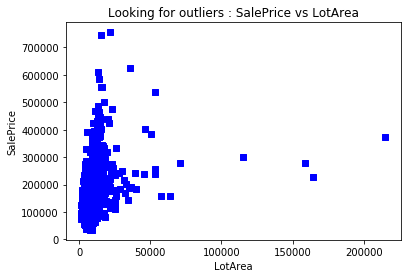

In [5]:
plt.figure()
plt.scatter(x = train.LotArea, y = train.SalePrice, c = 'blue', marker = 's')
plt.title('Looking for outliers : SalePrice vs LotArea')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show()

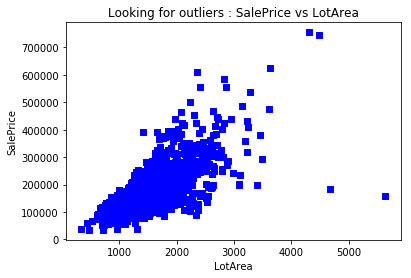

In [6]:
plt.figure()
plt.scatter(x = train.GrLivArea, y = train.SalePrice, c = 'blue', marker = 's')
plt.title('Looking for outliers : SalePrice vs LotArea')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show()

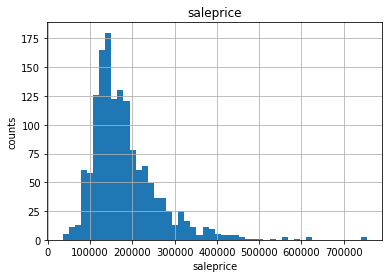

In [7]:
plt.figure()
train.SalePrice.hist(bins=50)
plt.title('saleprice')
plt.ylabel('counts')
plt.xlabel('saleprice')
plt.show()

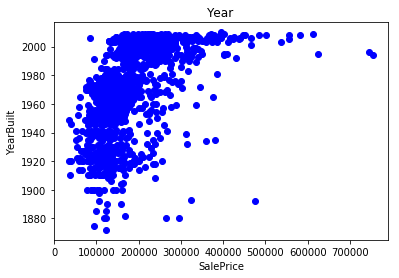

In [8]:
plt.figure()
plt.scatter(train.SalePrice,train.YearBuilt,c = 'blue' )
plt.title('Year')
plt.xlabel('SalePrice')
plt.ylabel('YearBuilt')
plt.show()

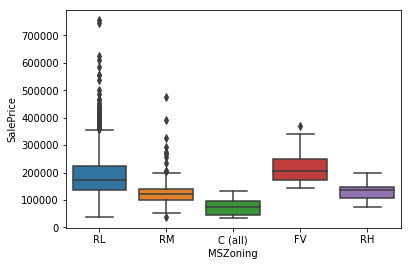

In [9]:
plt.figure()
sns.boxplot(train.MSZoning, train.SalePrice)
plt.show()

# prepare data

In [10]:
#modify categorical data
train_s = train.drop(['SalePrice'], axis = 1)
y = train['SalePrice']


all_data = pd.concat([train_s, test], axis = 0)
all_data.shape

(2919, 79)

In [11]:
all_data.isna().sum().sort_values(ascending = False)[:10]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
dtype: int64

In [12]:
# replace int64 into categorical values, for all columns
#replace numbers that are actually categories

all_data = all_data.replace({'MSSubClass' : { 20 : 'SC20', 30 : 'SC30', 40 : 'SC40', 45 : 'SC45', 50 : 'SC50',
                                             60 : 'SC60' , 70 : 'SC70', 
                                      75 : 'SC75', 80 : 'SC80', 85 : 'SC85', 90 : 'SC90', 120 : 'SC120', 
                                       150 : 'SC150', 160 : 'SC160', 180 : 'SC180', 190 : 'SC190'}, 
                       'MoSold' : { 1 : 'January', 2 : 'February', 3 : 'March', 4 : 'April', 5 : 'May' , 
                                   6 : 'June', 7 : 'July', 8 : 'August', 9 : 'September', 10 : 'October',
                                  11 : 'November', 12 : 'December'}})

In [13]:
# replace nans when they mean something

all_data.Alley = all_data.Alley.fillna('None')
all_data.BsmtQual = all_data.BsmtQual.fillna('NoBasement')
all_data.BsmtCond = all_data.BsmtCond.fillna('NoBasement')
all_data.BsmtExposure = all_data.BsmtExposure.fillna('NoBasement')
all_data.BsmtFinType1 = all_data.BsmtFinType1.fillna('NoBasement')
all_data.BsmtFinType2 = all_data.BsmtFinType2.fillna('NoBasement')
all_data.FireplaceQu = all_data.FireplaceQu.fillna('No')
all_data.GarageType = all_data.GarageType.fillna('No')
all_data.GarageFinish = all_data.GarageFinish.fillna('No')
all_data.GarageQual = all_data.GarageQual.fillna('No')
all_data.GarageCond = all_data.GarageCond.fillna('No')
all_data.PoolQC = all_data.PoolQC.fillna('No')
all_data.Fence = all_data.Fence.fillna('No')
all_data.MiscFeature = all_data.MiscFeature.fillna('No')
all_data.LotFrontage = all_data.LotFrontage.fillna(0)
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(0)

In [14]:
all_data.GarageYrBlt.isna().sum()

0

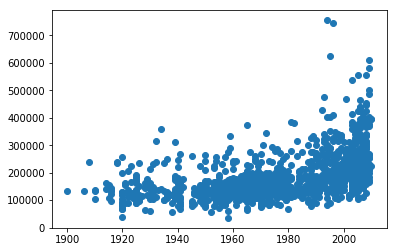

In [15]:
plt.figure()
plt.scatter(x = train.GarageYrBlt, y = train.SalePrice)
plt.show()

In [16]:
all_data.MasVnrType.value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

In [17]:
all_data.isna().sum().sort_values(ascending = False)[:15]

MasVnrType      24
MasVnrArea      23
MSZoning         4
Functional       2
BsmtHalfBath     2
BsmtFullBath     2
Utilities        2
SaleType         1
BsmtFinSF1       1
GarageCars       1
Electrical       1
Exterior2nd      1
KitchenQual      1
Exterior1st      1
TotalBsmtSF      1
dtype: int64

In [18]:
#first I wanna know what vars have more influence over SalePrice
train = all_data[:1460]
train_c = pd.concat([train,y], axis = 1)
correlation = train_c.corr('pearson')
correlation['SalePrice'][:10].sort_values(ascending = False)

OverallQual     0.791
YearBuilt       0.523
YearRemodAdd    0.507
MasVnrArea      0.477
BsmtFinSF1      0.386
LotArea         0.264
BsmtUnfSF       0.214
LotFrontage     0.210
BsmtFinSF2     -0.011
OverallCond    -0.078
Name: SalePrice, dtype: float64

In [19]:
train_s = all_data[:1460]
test = all_data[1460:]

In [20]:
import warnings
warnings.filterwarnings('ignore')

# simple imputation, divide into train and test to prevent data leakage

In [21]:
#categorical using most common vars
train_s.MasVnrType.fillna(train_s.MasVnrType.value_counts().idxmax(), inplace = True)
train_s.MSZoning.fillna(train_s.MSZoning.value_counts().idxmax(), inplace = True)
train_s.Utilities.fillna(train_s.Utilities.value_counts().idxmax(), inplace = True)
train_s.Functional.fillna(train_s.Functional.value_counts().idxmax(), inplace = True)
train_s.BsmtFullBath.fillna(train_s.BsmtFullBath.value_counts().idxmax(), inplace = True)
train_s.BsmtHalfBath.fillna(train_s.BsmtHalfBath.value_counts().idxmax(), inplace = True)
train_s.SaleType.fillna(train_s.SaleType.value_counts().idxmax(), inplace = True)
train_s.Electrical.fillna(train_s.Electrical.value_counts().idxmax(), inplace = True)
train_s.KitchenQual.fillna(train_s.KitchenQual.value_counts().idxmax(), inplace = True)
train_s.Exterior1st.fillna(train_s.Exterior1st.value_counts().idxmax(), inplace = True)
train_s.Exterior2nd.fillna(train_s.Exterior2nd.value_counts().idxmax(), inplace = True)
train_s.GarageQual.fillna(train_s.GarageQual.value_counts().idxmax(), inplace = True)
train_s.GarageCars.fillna(train_s.GarageCars.value_counts().idxmax(), inplace = True)

In [22]:
#categorical using most common vars
test.MasVnrType.fillna(test.MasVnrType.value_counts().idxmax(), inplace = True)
test.MSZoning.fillna(test.MSZoning.value_counts().idxmax(), inplace = True)
test.Utilities.fillna(test.Utilities.value_counts().idxmax(), inplace = True)
test.Functional.fillna(test.Functional.value_counts().idxmax(), inplace = True)
test.BsmtFullBath.fillna(test.BsmtFullBath.value_counts().idxmax(), inplace = True)
test.BsmtHalfBath.fillna(test.BsmtHalfBath.value_counts().idxmax(), inplace = True)
test.SaleType.fillna(test.SaleType.value_counts().idxmax(), inplace = True)
test.Electrical.fillna(test.Electrical.value_counts().idxmax(), inplace = True)
test.KitchenQual.fillna(test.KitchenQual.value_counts().idxmax(), inplace = True)
test.Exterior1st.fillna(test.Exterior1st.value_counts().idxmax(), inplace = True)
test.Exterior2nd.fillna(test.Exterior2nd.value_counts().idxmax(), inplace = True)
test.GarageQual.fillna(test.GarageQual.value_counts().idxmax(), inplace = True)
test.GarageCars.fillna(test.GarageCars.value_counts().idxmax(), inplace = True)

In [23]:
all_data.GarageCars.value_counts().idxmax()

2.0

In [24]:
#numericals using median
#train_s.MasVnrArea.fillna(train_s.MasVnrArea.median(), inplace = True)
train_s.MasVnrArea.fillna(train_s.MasVnrArea.median(), inplace = True)
train_s.BsmtFinSF1.fillna(train_s.BsmtFinSF1.median(), inplace = True)
train_s.BsmtFinSF2.fillna(train_s.BsmtFinSF2.median(), inplace = True)
train_s.BsmtUnfSF.fillna(train_s.BsmtUnfSF.median(), inplace = True)
train_s.TotalBsmtSF.fillna(train_s.TotalBsmtSF.median(), inplace = True)

train_s.GarageArea.fillna(train_s.GarageArea.median(), inplace = True)

In [25]:
#numericals using median
#test.MasVnrArea.fillna(test.MasVnrArea.median(), inplace = True)
test.MasVnrArea.fillna(test.MasVnrArea.median(), inplace = True)
test.BsmtFinSF1.fillna(test.BsmtFinSF1.median(), inplace = True)
test.BsmtFinSF2.fillna(test.BsmtFinSF2.median(), inplace = True)
test.BsmtUnfSF.fillna(test.BsmtUnfSF.median(), inplace = True)
test.TotalBsmtSF.fillna(test.TotalBsmtSF.median(), inplace = True)

test.GarageArea.fillna(test.GarageArea.median(), inplace = True)

In [26]:
all_data = pd.concat([train_s, test], axis = 0)
all_data.shape

(2919, 79)

In [27]:
all_data.isna().sum().sort_values(ascending = False)[:5]

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

In [28]:
# replace cat vars into numbers when there is information in the order

all_data = all_data.replace({'Utilities' : {'ELO' : 0, 'NoSeWa' : 1, 'NoSewr' : 2, 'AllPub' : 3},
                            'LandSlope' : {'Sev' : 0, 'Mod' : 1, 'Gtl' : 2}, 
                            'ExterQual' : {'Po' : 0, 'Fa' : 0, 'TA' : 0, 'Gd' : 1, 'Ex' : 2}, 
                            'ExterCond' : {'Po' : 0, 'Fa' : 0, 'TA' : 1, 'Gd' : 2, 'Ex' : 3},
                            'BsmtQual' : {'NoBasement' : 0, 'Po' : 1, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
                            'BsmtCond' : {'NoBasement' : 0, 'Po' : 1, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
                            'BsmtExposure' : {'NoBasement' : 0, 'No' : 1, 'Mn' : 2, 'Av' : 3, 'Gd' : 4},
                            'BsmtFinType1' : {'NoBasement' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5,
                                             'GLQ' : 6},
                            'BsmtFinType2' : {'NoBasement' : 0, 'Unf' : 1, 'LwQ' : 2, 'Rec' : 3, 'BLQ' : 4, 'ALQ' : 5,
                                             'GLQ' : 6},
                            'HeatingQC' : {'Po' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
                            'CentralAir' : {'No' : 0, 'Yes' : 1},
                            'KitchenQual' : {'Po' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
                            'Functional' : {'Sev' : 0, 'Maj2' : 1, 'Maj1' : 2, 'Mod' : 3, 'Min1' : 4,
                                            'Min2' : 5, 'Typ' : 6},
                            'FireplaceQu' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                            'GarageQual' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                            'GarageCond' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                            'PoolQC' : {'No' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
                            'Fence' : {'No' : 0, 'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4}}
                            )

In [29]:
all_data = all_data.drop(['Utilities'], axis = 1)

In [30]:
all_data = all_data.drop(['Street', 'Alley'], axis = 1)



all_data['LotShape'] = all_data.loc[:, 'LotShape'].map(lambda x: 1 if x == 'Reg' else 0)
all_data['LandContour'] = all_data.loc[:, 'LandContour'].map(lambda x: 1 if x == 'Lvl' else 0)
all_data['LotConfig'] = all_data.loc[:, 'LotConfig'].map(lambda x: 0 if x == 'Inside' else 1 if x == 'Corner' else 2)
all_data['Condition1'] = all_data.loc[:, 'Condition1'].map(lambda x: 0 if x == 'Norm' else 1)
all_data['Condition2'] = all_data.loc[:, 'Condition2'].map(lambda x: 0 if x == 'Norm' else 1)
all_data['RoofMatl'] = all_data.loc[:, 'RoofMatl'].map(lambda x : 0 if x == 'CompShg' else 1)
all_data['CentralAir'] = all_data.loc[:, 'CentralAir'].map(lambda x : 0 if x == 'N' else 1)
all_data['Electrical'] = all_data.loc[:, 'Electrical'].map(lambda x : 0 if x == 'SBrkr' else 1)
all_data['PavedDrive'] = all_data.loc[:, 'PavedDrive'].map(lambda x : 0 if x == 'Y' else 1)
all_data['MiscFeature'] = all_data.loc[:, 'MiscFeature'].map(lambda x : 0 if x == 'No' else 1)

In [31]:
all_data['BsmtCond'].value_counts()

2    2606
3     122
1     109
0      82
Name: BsmtCond, dtype: int64

In [32]:
all_data[:3]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,SC60,RL,65.000,8450,1,1,0,2,CollgCr,0,...,0,0,0,0,0,0,February,2008,WD,Normal
2,SC20,RL,80.000,9600,1,1,2,2,Veenker,1,...,0,0,0,0,0,0,May,2007,WD,Normal
3,SC60,RL,68.000,11250,0,1,0,2,CollgCr,0,...,0,0,0,0,0,0,September,2008,WD,Normal


In [33]:
train = all_data[:1460]
test = all_data[1460:]
train = pd.concat([train, y], axis = 1)
print('train : '+ str(train.shape))
print('test : '+ str(test.shape))

train : (1460, 77)
test : (1459, 76)


# feature selection

## first,  let us drop correlated vars

In [34]:
quant_vars_all = train.select_dtypes(include = ['number']).drop('SalePrice', axis = 1)
cat_vars_all = train.select_dtypes(exclude = ['number'])
print('quant vars are : ' , quant_vars_all.shape)
print('cat vars are : ', cat_vars_all.shape)

quant vars are :  (1460, 60)
cat vars are :  (1460, 16)


In [35]:
#numerical columns
columns = list(quant_vars_all.columns)

In [36]:
quant_vars_all.corr('pearson').style.format('{:.2}').background_gradient(cmap= plt.get_cmap('coolwarm'), axis = 1)

In [37]:
#drop correlated columns

cols_to_drop = ['GarageCond', 'PoolQC', 'GarageCars', 'FireplaceQu', 'BsmtFinType1', 'BsmtFinType2',
                'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'TotalBsmtSF']
train = train.drop(cols_to_drop, axis = 1)
test = test.drop(cols_to_drop, axis = 1)

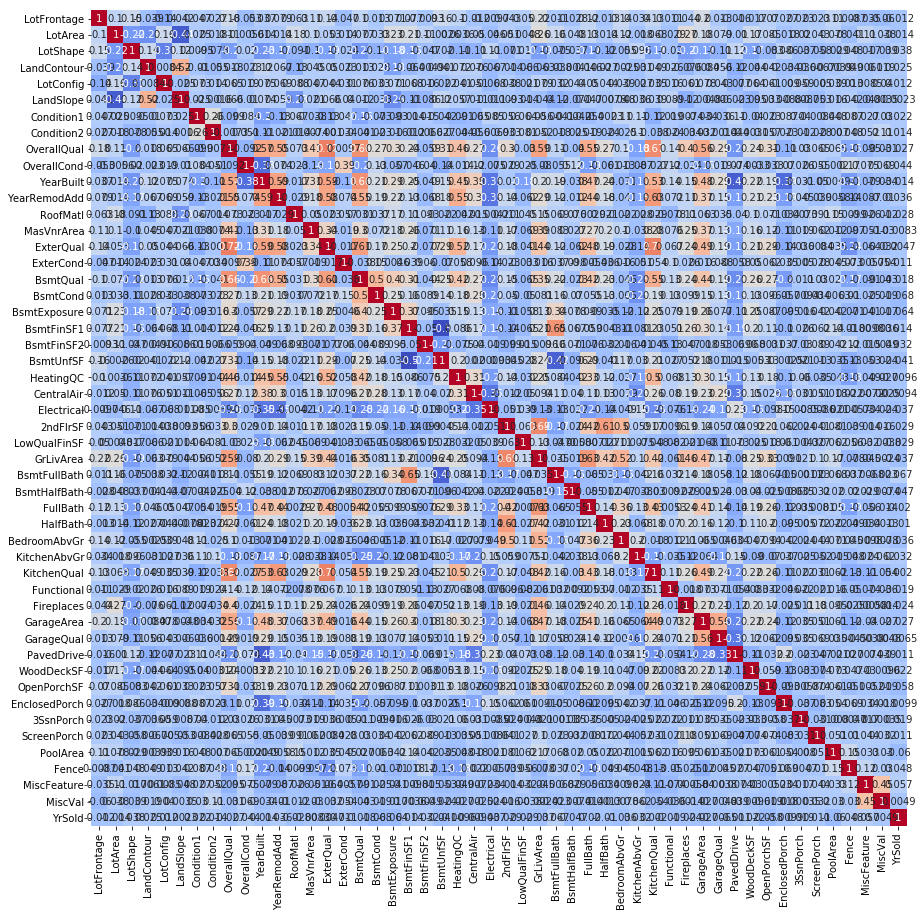

In [38]:
correlation = quant_vars_all.drop(cols_to_drop, axis = 1).corr('pearson')
plt.figure(figsize=(20,15))
sns.heatmap(correlation, annot=True, square=True, cbar=False, cmap = 'coolwarm')
plt.show()

In [39]:
correlation[correlation<1].max().sort_values(ascending = False)[:10]

ExterQual      0.717
OverallQual    0.717
KitchenQual    0.708
2ndFlrSF       0.688
GrLivArea      0.688
BsmtQual       0.661
YearBuilt      0.657
BsmtFullBath   0.649
BsmtFinSF1     0.649
FullBath       0.630
dtype: float64

## cat vars

## all is done using train, the same has to be done with test to avoid data leakage

## get dummies after transforming variables

In [40]:
cat_vars_all.shape

(1460, 16)

In [41]:
cat_vars_all.columns

Index(['MSSubClass', 'MSZoning', 'Neighborhood', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'GarageType', 'GarageFinish', 'MoSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [42]:
cat_vars_all.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

## numerical variables to transform

In [43]:
numerical_features = train.select_dtypes(include = ['number'])
numerical_features.columns

Index(['LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Condition1', 'Condition2', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', 'Electrical',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'Functional', 'Fireplaces', 'GarageArea', 'GarageQual', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'Fence', 'MiscFeature', 'MiscVal', 'YrSold',
       'SalePrice'],
      dtype='object')

# transform variables


 mu = 180921.20 and sigma = 79415.29



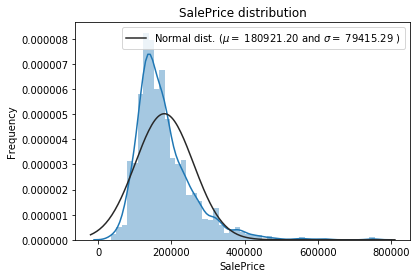

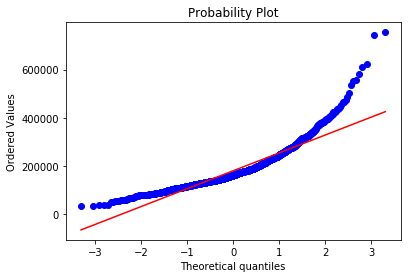

In [44]:
# Visualizing SalePrice vs. log(SalePrice)
# import seaborn and fit and skew functions from scipy
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics




# Plotting Saleprice Distribution
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

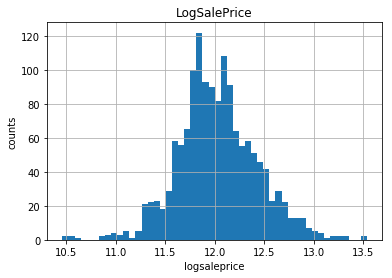


 mu = 12.02 and sigma = 0.40



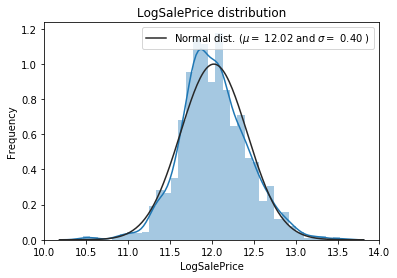

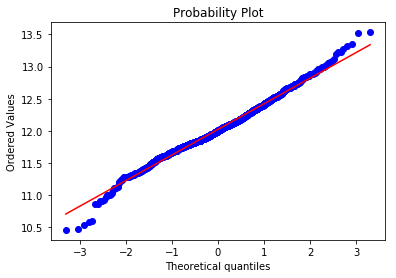

In [45]:
#log transform 
train['LogSalePrice'] = np.log1p(train.SalePrice)
plt.figure()
train.LogSalePrice.hist(bins=50)
plt.title('LogSalePrice')
plt.ylabel('counts')
plt.xlabel('logsaleprice')
plt.show()

# Plotting Saleprice Distribution
sns.distplot(train['LogSalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['LogSalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogSalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['LogSalePrice'], plot=plt)
plt.show()

In [46]:
#remove SalePrice
train = train.drop('SalePrice', axis = 1)


 mu = 57.62 and sigma = 34.65



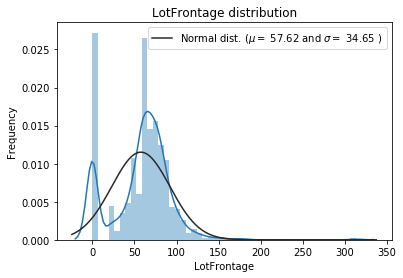

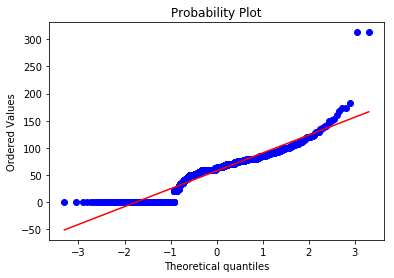

In [47]:
# Plotting LotFrontage Distribution
sns.distplot(train['LotFrontage'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['LotFrontage'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LotFrontage distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['LotFrontage'], plot=plt)
plt.show()


 mu = 4.21 and sigma = 0.35



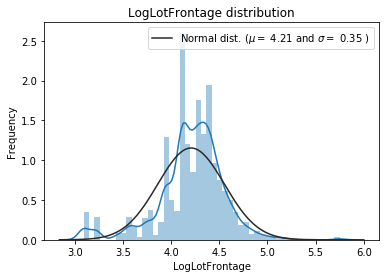

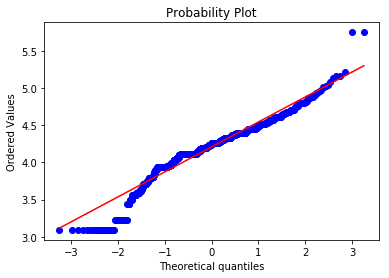

In [48]:
train['BinaryLotFrontage'] = 0
train.loc[train['LotFrontage'] > 0, 'BinaryLotFrontage'] = 1
train.loc[train['BinaryLotFrontage'] == 1, 'LogLotFrontage'] = np.log1p(train['LotFrontage'])


sns.distplot(train[train['BinaryLotFrontage']>0]['LogLotFrontage'], fit = norm)


# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[train['BinaryLotFrontage']>0]['LogLotFrontage'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogLotFrontage distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train[train['BinaryLotFrontage']>0]['LogLotFrontage'], plot=plt)
plt.show()


train['LogLotFrontage'] = train['LogLotFrontage'].fillna(0)
train['LogLotFrontage'].isna().any()


train = train.drop('LotFrontage', axis = 1)


 mu = 4.19 and sigma = 0.35



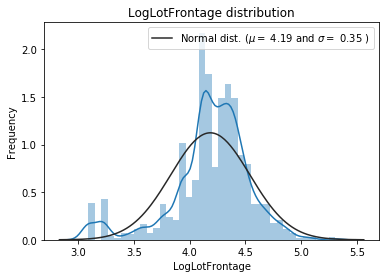

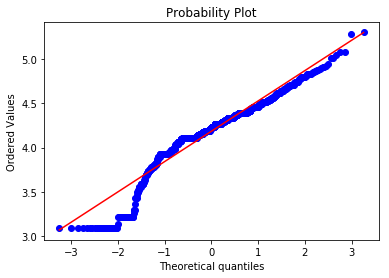

In [49]:
test['BinaryLotFrontage'] = 0
test.loc[test['LotFrontage'] > 0, 'BinaryLotFrontage'] = 1
test.loc[test['BinaryLotFrontage'] == 1, 'LogLotFrontage'] = np.log1p(test['LotFrontage'])


sns.distplot(test[test['BinaryLotFrontage']>0]['LogLotFrontage'], fit = norm)


# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test[test['BinaryLotFrontage']>0]['LogLotFrontage'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogLotFrontage distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test[test['BinaryLotFrontage']>0]['LogLotFrontage'], plot=plt)
plt.show()


test['LogLotFrontage'] = test['LogLotFrontage'].fillna(0)
test['LogLotFrontage'].isna().any()


test = test.drop('LotFrontage', axis = 1)


 mu = 346.99 and sigma = 436.38



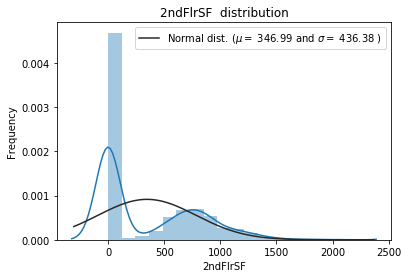

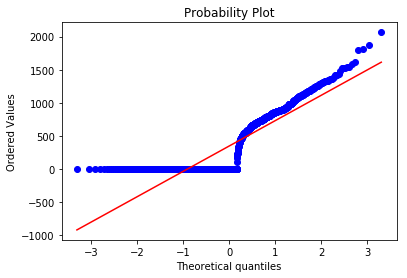

In [50]:
# Plotting 2ndFlrSF Distribution
sns.distplot(train['2ndFlrSF'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['2ndFlrSF'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('2ndFlrSF  distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['2ndFlrSF'], plot=plt)
plt.show()


 mu = 6.63 and sigma = 0.37



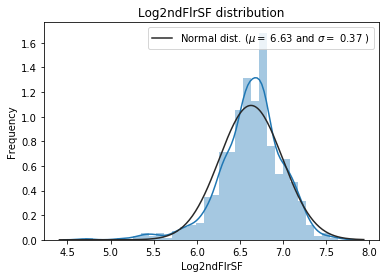

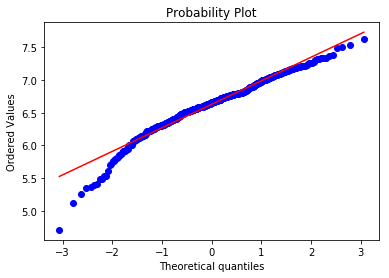

False

In [51]:
train['Binary2ndFlrSF'] = 0
train.loc[train['2ndFlrSF'] > 0, 'Binary2ndFlrSF'] = 1
train.loc[train['Binary2ndFlrSF'] == 1, 'Log2ndFlrSF'] = np.log1p(train['2ndFlrSF'])


sns.distplot(train[train['Binary2ndFlrSF']>0]['Log2ndFlrSF'], fit = norm)


# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[train['Binary2ndFlrSF']>0]['Log2ndFlrSF'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log2ndFlrSF distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train[train['Binary2ndFlrSF']>0]['Log2ndFlrSF'], plot=plt)
plt.show()

train = train.drop('2ndFlrSF', axis = 1)

train['Log2ndFlrSF'] = train['Log2ndFlrSF'].fillna(0)
train['Log2ndFlrSF'].isna().any()



 mu = 6.58 and sigma = 0.38



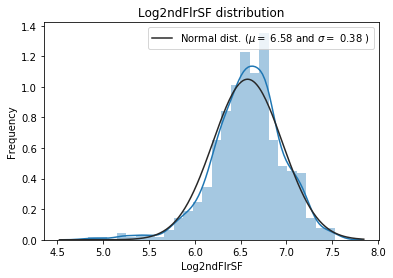

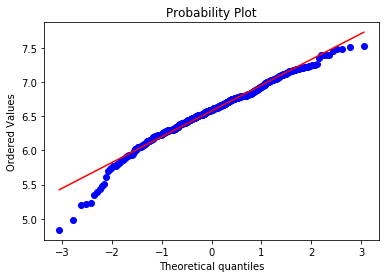

False

In [52]:
test['Binary2ndFlrSF'] = 0
test.loc[test['2ndFlrSF'] > 0, 'Binary2ndFlrSF'] = 1
test.loc[test['Binary2ndFlrSF'] == 1, 'Log2ndFlrSF'] = np.log1p(test['2ndFlrSF'])


sns.distplot(test[test['Binary2ndFlrSF']>0]['Log2ndFlrSF'], fit = norm)


# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test[test['Binary2ndFlrSF']>0]['Log2ndFlrSF'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log2ndFlrSF distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test[test['Binary2ndFlrSF']>0]['Log2ndFlrSF'], plot=plt)
plt.show()

test = test.drop('2ndFlrSF', axis = 1)

test['Log2ndFlrSF'] = test['Log2ndFlrSF'].fillna(0)
test['Log2ndFlrSF'].isna().any()


 mu = 472.98 and sigma = 213.73



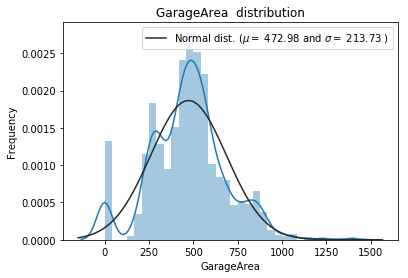

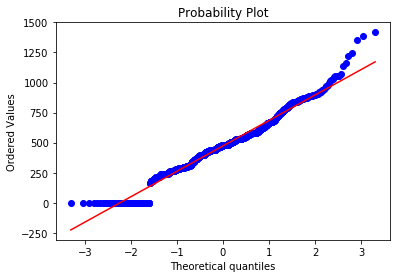


 mu = 6.15 and sigma = 0.38



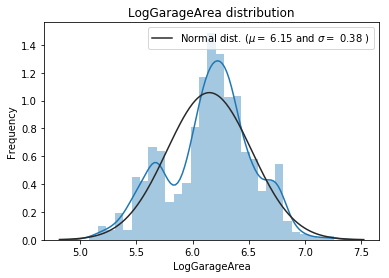

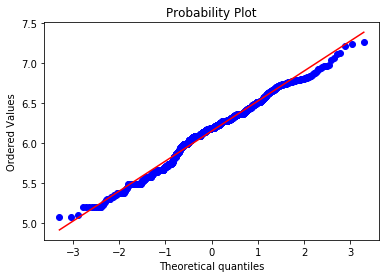

In [53]:
# Plotting GarageArea Distribution
sns.distplot(train['GarageArea'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['GarageArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GarageArea  distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['GarageArea'], plot=plt)
plt.show()


train['BinaryGarageArea'] = 0
train.loc[train['GarageArea'] > 0, 'BinaryGarageArea'] = 1
train.loc[train['BinaryGarageArea'] == 1, 'LogGarageArea'] = np.log1p(train['GarageArea'])


sns.distplot(train[train['BinaryGarageArea']>0]['LogGarageArea'], fit = norm)


# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[train['BinaryGarageArea']>0]['LogGarageArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogGarageArea distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train[train['BinaryGarageArea']>0]['LogGarageArea'], plot=plt)
plt.show()

train['LogGarageArea'] = train['LogGarageArea'].fillna(0)
train['LogGarageArea'].isna().any()

train = train.drop('GarageArea', axis = 1)


 mu = 472.77 and sigma = 216.90



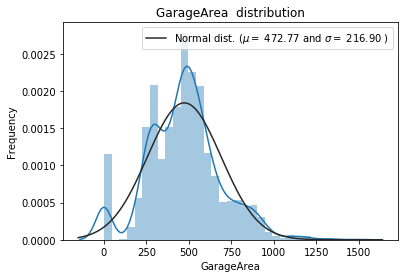

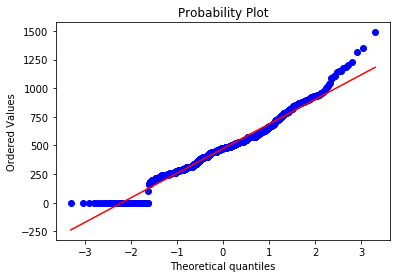


 mu = 6.14 and sigma = 0.39



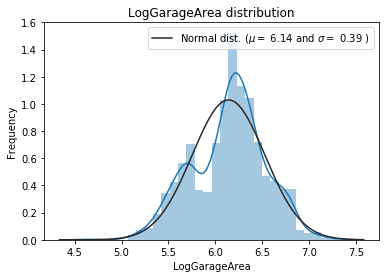

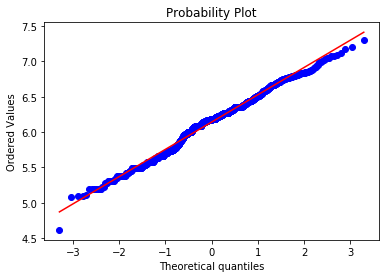

In [54]:
# Plotting GarageArea Distribution
sns.distplot(test['GarageArea'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test['GarageArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('GarageArea  distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test['GarageArea'], plot=plt)
plt.show()


test['BinaryGarageArea'] = 0
test.loc[test['GarageArea'] > 0, 'BinaryGarageArea'] = 1
test.loc[test['BinaryGarageArea'] == 1, 'LogGarageArea'] = np.log1p(test['GarageArea'])


sns.distplot(test[test['BinaryGarageArea']>0]['LogGarageArea'], fit = norm)


# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(test[test['BinaryGarageArea']>0]['LogGarageArea'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('LogGarageArea distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(test[test['BinaryGarageArea']>0]['LogGarageArea'], plot=plt)
plt.show()

test['LogGarageArea'] = test['LogGarageArea'].fillna(0)
test['LogGarageArea'].isna().any()

test = test.drop('GarageArea', axis = 1)

## transform some vars above, transform only numerical (float64) vars, skewness?



In [55]:
train_y = train['LogSalePrice']
train = train.drop('LogSalePrice', axis = 1)
numeric_feats = train.dtypes[train.dtypes != 'object'].index
# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.452
PoolArea,14.813
LotArea,12.195
3SsnPorch,10.294
Condition2,9.713
LowQualFinSF,9.002
RoofMatl,7.292
MiscFeature,4.907
KitchenAbvGr,4.484
BsmtFinSF2,4.251


In [56]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    train[feat] = boxcox1p(train[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 53 skewed numerical features to Box Cox transform


In [57]:
train.isna().sum().sort_values(ascending = False)[:3]

LogGarageArea    0
Foundation       0
Exterior1st      0
dtype: int64

In [59]:
#get dummies
all_data = pd.concat([train, test] , axis = 0 )
print('all_data shape is :' ,all_data.shape)


all_data_dm = pd.get_dummies(all_data, drop_first=True)
print('all_data_dm is :', all_data_dm.shape)
    

all_data shape is : (2919, 69)
all_data_dm is : (2919, 187)


# nan stuff already done

# standarize for detecting outliers in train dataset

In [60]:
train_x = all_data_dm[:1460]
train = pd.concat([train_x, train_y], axis = 1)
test = all_data_dm[1460:]
print(train.shape)
print(test.shape)

(1460, 188)
(1459, 187)


# outliers removal considering train_out

In [61]:
from outliers import outliers

In [62]:
%load_ext autoreload
%autoreload 2

In [63]:
temp = outliers(train, list(train.columns), kneighbors = 40)

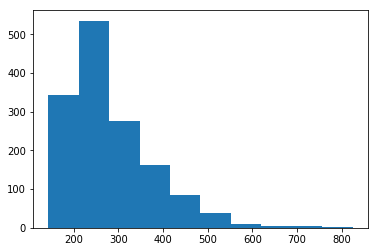

In [64]:
plt.hist(temp.distances)
plt.show()

In [65]:
q_99 = temp.distances.quantile(q = 0.999)

In [66]:
temp.distances.sort_values(ascending = False)
sum(temp.distances>q_99)

2

In [67]:
train['distances'] = temp.distances
train.shape

(1460, 189)

# remove outliers

In [68]:
train = train.loc[train.distances < q_99,]
train = train.drop('distances', axis = 1)
print(train.shape)

(1457, 188)


In [70]:
train_clean = train

# outliers done

# scaling all predictors

In [71]:
train_y = train_clean['LogSalePrice']
train_x = train_clean.drop('LogSalePrice', axis = 1)
print(train_x.shape)
print(train_y.shape)

(1457, 187)
(1457,)


In [72]:
scaler = RobustScaler()
train_sc = pd.DataFrame(scaler.fit_transform(train_x.values), columns = train_x.columns)
test_sc = pd.DataFrame(scaler.fit_transform(test.values), columns = test.columns)

In [73]:
print('train shape is:', train_sc.shape)
print('test shape is:', test_sc.shape)

train shape is: (1457, 187)
test shape is: (1459, 187)


In [74]:
train_sc.to_csv('iowa_housing_test_data/train_x_prep.csv', index = False)
test_sc.to_csv('iowa_housing_test_data/test_prep.csv', index = False)
train_y.to_csv('iowa_housing_test_data/train_y_prep.csv', index = False)